# Veloce Gain

Steps:
1. measure bias overscan + remove gaps
2. get master flat
3. extract flats to get flux in fibers 
4. determine flux ratio on quadrants crossings

In [1]:
# import gc
# import pickle
import os
import numpy as np
import matplotlib.pyplot as plt

# from csaps import csaps
from astropy.io import fits
from matplotlib.patches import Rectangle

In [ ]:
from simple_veloce_reduction import veloce_reduction_tools, veloce_config, veloce_extraction

In [3]:
%matplotlib inline

### Load Flat

In [4]:
# amp_mode = 4
data_path = '/home/usqobserver2/VeloceData'
run = 'Gain_test'
config, veloce_paths = veloce_config.load_config('config.yaml')

 does not match run name: CSV_Run


In [5]:
obs_list = veloce_config.load_run_logs(
            config['science_targets'], config['arm'], veloce_paths)

In [6]:
arm = 'red'

In [7]:
filename = os.path.join('/home/usqobserver2/Joachim_veloce/veloce_reduction_dev/veloce_reduction/Trace', f'veloce_{arm}_4amp_no_sim_calib_trace.pkl')
traces = veloce_reduction_tools.Traces.load_traces(filename)

In [8]:
flat_image = veloce_extraction.get_flat(veloce_paths, arm, config['amplifier_mode'], '230826', obs_list)

In [9]:
# %matplotlib widget

In [10]:
# np.min(flat_image), np.max(flat_image), np.mean(flat_image), np.std(flat_image)

Text(0.5, 1.0, 'Fiber flat - pixel sensitivity map')

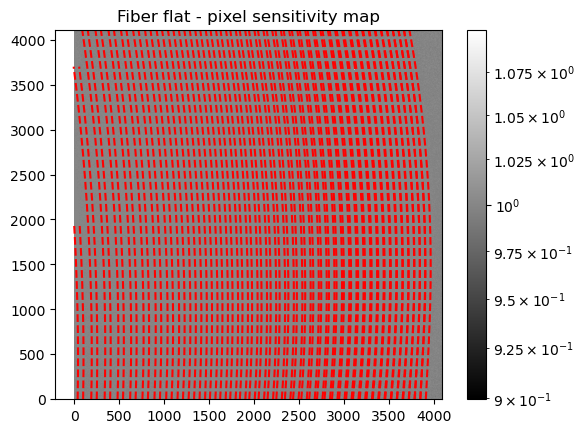

In [11]:
### 
plt.close()
f_min = np.median(flat_image)-5*np.std(flat_image)
f_max = np.median(flat_image)+5*np.std(flat_image)
plt.imshow(flat_image, origin='lower', vmin=f_min, vmax=f_max, norm='log', cmap='gray')
for y, x, low, up in traces:
    # plt.plot(x, y, 'r-')
    plt.plot(x+up, y, 'r--')
    plt.plot(x-low, y, 'r--')
plt.colorbar()
plt.title('Fiber flat - pixel sensitivity map')

In [12]:
sorted_flat_image = np.sort(flat_image.flatten(), axis=None)

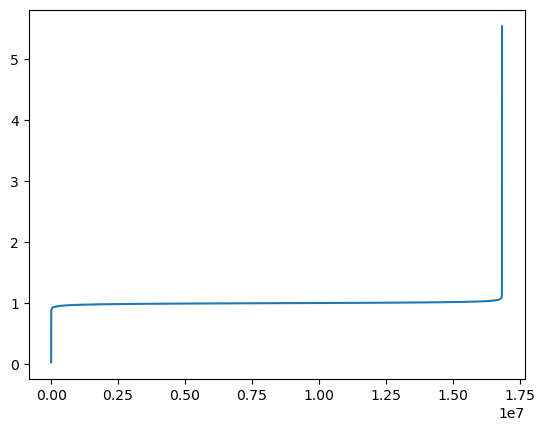

In [13]:
plt.close()
plt.plot(sorted_flat_image)

In [ ]:
def get_master_mmap(obs_list, master_type, data_path, date, arm, amp_mode):
    """
    Generates a master frame by median combining individual frames for a given observation type and date using memory-mapped files.

    Parameters:
    - obs_list (dict): A nested dictionary where the first key is the master type (e.g., 'bias', 'flat'), the
      second key is the date, and the value is a list of file names for that observation type and date.
    - master_type (str): The type of master frame to generate (e.g., 'bias', 'flat').
    - data_path (str): The base path to the directory containing the observation data.
    - date (str): The date of the observation, used to select the correct set of files from the observation list.
    - arm (str): The spectral arm ('red', 'green', 'blue') of the data to process, which determines the CCD to use.

    Returns:
    - numpy.ndarray: A 2D numpy array representing the median-combined master frame for the specified observation
      type, date, and spectral arm.

    Raises:
    - KeyError: If the specified `arm` is not one of 'red', 'green', or 'blue'.
    - FileNotFoundError: If any of the FITS files specified in the observation list cannot be found at the
      constructed file path.
    """
    data_sub_dirs = {'red': 'ccd_3', 'green': 'ccd_2', 'blue': 'ccd_1'}
    file_list = obs_list[master_type][date]
    num_files = len(file_list)

    if num_files == 0:
        raise ValueError("No files found for the specified master type and date.")

    # Read the first file to get the shape of the data
    # Load placeholder header from the first file 
    # TODO: edit header to reflect that it is a median combined frame
    first_file = os.path.join(data_path, date, data_sub_dirs[arm], file_list[0])
    with fits.open(first_file) as hdul:
        frame_shape = veloce_reduction_tools.remove_overscan_bias(hdul[0].data, hdul[0].header, arm=arm,
                                        amplifier_mode=amp_mode, overscan_range=32).shape
        header = hdul[0].header

    # Create a memory-mapped file to store the frames
    mmap_file = np.memmap('frames.dat', dtype='float32', mode='w+', shape=(num_files, *frame_shape))
    flat_stats = np.zeros((num_files, 5))
    # Read each FITS file and store the data in the memory-mapped file
    for i, file_name in enumerate(file_list):
        fits_image_filename = os.path.join(data_path, date, data_sub_dirs[arm], file_name)
        print(file_name)
        with fits.open(fits_image_filename) as hdul:
            flat = veloce_reduction_tools.remove_overscan_bias(hdul[0].data, hdul[0].header, arm=arm,
                                        amplifier_mode=amp_mode, overscan_range=32)
            # flat, hdr = get_normalised_master_flat(flat, hdul[0].header)
            mmap_file[i] = flat
            flat_stats[i] = (np.median(flat), np.mean(flat), np.std(flat), np.min(flat), np.max(flat))

    # Calculate the median along the first axis
    master_frame = np.median(mmap_file, axis=0)

    # Clean up the memory-mapped file
    del mmap_file
    os.remove('frames.dat')

    return master_frame, header, flat_stats

In [ ]:
means = []
dates = []
for date in obs_list[f'flat_{arm}']:
    # Get the master flat frame for the specified date
    try:
        master_flat, header, flat_stats = get_master_mmap(obs_list, f'flat_{arm}', veloce_paths.input_dir, date, arm, config['amplifier_mode'])
        means.append(flat_stats[:, 1])
        dates.append(date)
    except Exception as e:
        print(f"Error processing date {date}: {e}")
        continue

Gain for quadrant 1: 1.01
Gain for quadrant 2: 1.01
Gain for quadrant 3: 1.01
Gain for quadrant 4: 1.01
Gain for quadrant 1: 1.01
Gain for quadrant 2: 1.01
Gain for quadrant 3: 1.01
Gain for quadrant 4: 1.01
Gain for quadrant 1: 1.01
Gain for quadrant 2: 1.01
Gain for quadrant 3: 1.01
Gain for quadrant 4: 1.01
Gain for quadrant 1: 1.01
Gain for quadrant 2: 1.01
Gain for quadrant 3: 1.01
Gain for quadrant 4: 1.01
Gain for quadrant 1: 1.01
Gain for quadrant 2: 1.01
Gain for quadrant 3: 1.01
Gain for quadrant 4: 1.01
Gain for quadrant 1: 1.01
Gain for quadrant 2: 1.01
Gain for quadrant 3: 1.01
Gain for quadrant 4: 1.01
Gain for quadrant 1: 1.01
Gain for quadrant 2: 1.01
Gain for quadrant 3: 1.01
Gain for quadrant 4: 1.01
Gain for quadrant 1: 1.01
Gain for quadrant 2: 1.01
Gain for quadrant 3: 1.01
Gain for quadrant 4: 1.01
Gain for quadrant 1: 1.01
Gain for quadrant 2: 1.01
Gain for quadrant 3: 1.01
Gain for quadrant 4: 1.01
Gain for quadrant 1: 1.01
Gain for quadrant 2: 1.01
Gain for qua

In [ ]:
# master_flat = veloce_reduction_tools.get_master_mmap(obs_list, f'flat_{arm}', os.path.join(data_path, run), '230826', arm, 4)
# master_flat, hdr, stats = get_master_mmap(obs_list, f'flat_{arm}', veloce_paths.input_dir, '230828', arm, 4)

In [ ]:
means = [_mean for _mean in means if len(_mean) > 10]

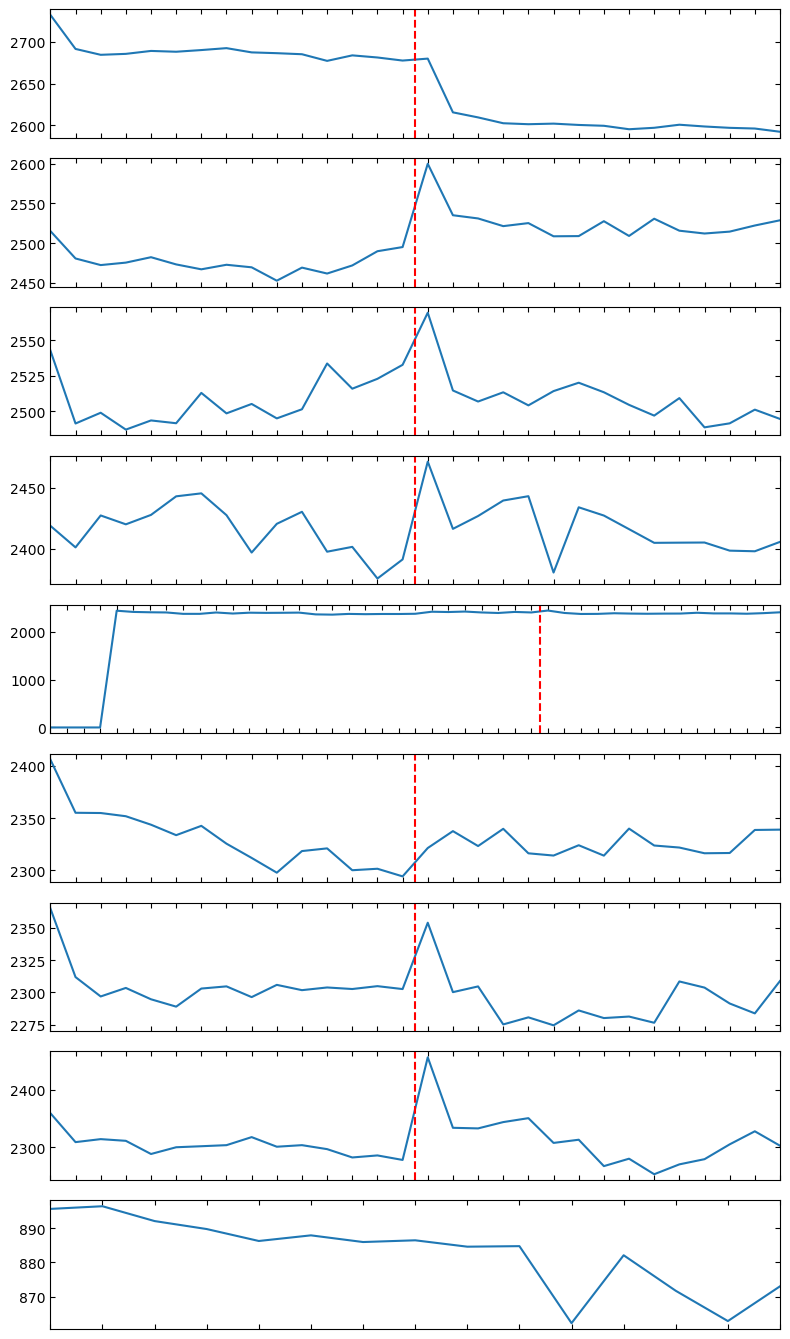

In [ ]:
fig, ax = plt.subplots(len(means),1, figsize=(8, 1.5*len(means)))

for i, _means in enumerate(means):
    date = dates[i]
    ax[i].plot(_means,label=f'mean value of flats {date}')
    # ax[i].tick_params(axis='both', direction='in')
    ax[i].tick_params(axis='x', direction='in', top=True, labeltop=False, bottom=True, labelbottom=False)
    ax[i].tick_params(axis='y', direction='in', left=True, labelleft=True, right=True, labelright=False)
    xticks = np.arange(len(obs_list[f'flat_{arm}'][date]))
    ax[i].set_xticks(xticks)
    ax[i].set_xlim(min(xticks), max(xticks))
    xticklabels = [f'{obs_list[f"flat_{arm}"][date][j][6:10]}' for j in range(len(obs_list[f'flat_{arm}'][date]))]
    # ax[i].set_xticklabels(xticklabels, rotation=45)
    ax[i].set_xticklabels([])
    xticklabels = np.array(xticklabels, dtype=int)
    if np.max(np.diff(xticklabels)) > 2:
        diff_position = np.argmax(np.diff(xticklabels))
        ax[i].axvline(diff_position+0.5, color='r', linestyle='--')
plt.subplots_adjust(wspace=0, hspace=0)
plt.tick_params(axis='both', direction='in')
plt.tight_layout()

In [ ]:
# plot_type = ['median', 'mean', 'std', 'min', 'max']
# fig, ax = plt.subplots(5,1, figsize=(10,10))
# diff_position = np.argmax(np.diff(np.array([float(f[6:9]) for f in obs_list[f'flat_{arm}']['230828'][4:]])))
# print(diff_position)
# for i in range(len(stats[0])):
#     ax[i].plot(stats[4:, i],label=f'{plot_type[i]}')
#     ax[i].axvline(diff_position+0.5, color='r', linestyle='--')
#     ax[i].set_xticks(np.arange(len(obs_list[f'flat_{arm}']['230828'][4:])))
#     ax[i].set_xticklabels([])
# ax[-1].set_xticklabels(obs_list[f'flat_{arm}']['230828'][4:], rotation=90)
# plt.subplots_adjust(hspace=0)  

In [ ]:
# amp_mode_2 = 2
# data_path = '/home/usqobserver2/VeloceData'
# run_2 = 'Delta_Call_2025_accretion'
# night_2 = '250404'
# # ccd = 'ccd_3'
# # arm = 'red'
# # filename = f'04apr30015.fits' #red
# ccd = 'ccd_2'
# arm = 'green'
# filename_2 = f'04apr20025.fits' #green
# # ccd = 'ccd_1'
# # arm = 'blue'
# # filename_2 = f'04apr10220.fits' #blue

In [ ]:
# master_flat, header, flat_stats = get_master_mmap(obs_list, f'flat_{arm}', veloce_paths.input_dir, date, arm, config['amplifier_mode'])
